In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.dates import DateFormatter
import datetime
from datetime import datetime, timedelta
import os
os.chdir("/content/drive/MyDrive/projects/DailyElectricityPriceandDemandData/")
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

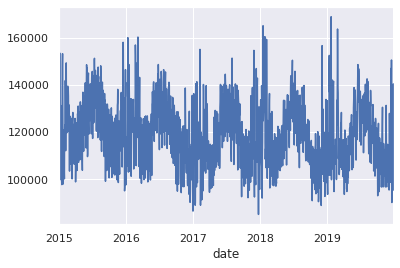

In [2]:
# 目的変数のプロット
df = pd.read_csv("data/complete_dataset.csv", index_col=0, parse_dates=True)
df = df.loc[:"2019-12-31"]
df["demand"].plot()

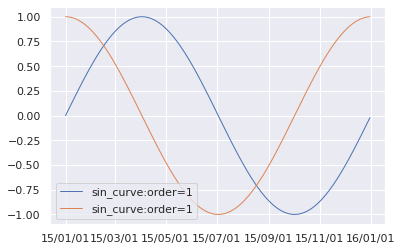

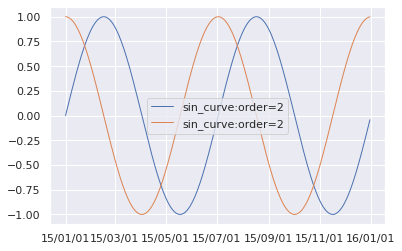

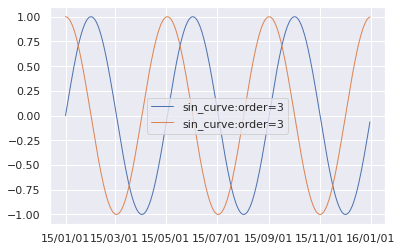

In [3]:
y = df["demand"].loc["2015-01-01" : "2015-12-31"]
index = y.index
freq = 365.25
order = 3

time = np.arange(len(index), dtype=np.float32)
k = 2 * np.pi * (1 / freq) * time
features = {}
for i in range(1, order + 1):
  # 1年(365.25日)でi周するsin, cos波を作る
  sin_curve = np.sin(i * k)
  cos_curve = np.cos(i * k)
  
  fig = plt.figure()
  ax =fig.add_subplot(111)
  ax.plot(index, sin_curve, linewidth=1.0, label=f"sin_curve:order={i}")
  ax.plot(index, cos_curve, linewidth=1.0, label=f"sin_curve:order={i}")
  ax.xaxis.set_major_formatter(DateFormatter("%y/%m/%d"))
  plt.legend()
  plt.show()
plt.close()

週+年の周期的な動きをフーリエ級数展開で再現する  

今回はProphetを参考に1週間周期を3個のsin, cosのペアで、1年周期を10個のsin, cosのペアで表現する


In [4]:
# データ作り
# 時刻tの成分を sin(2π * order_num * t / 7)で表すイメージ
y = df["demand"].loc[:"2019-12-31"]
index = y.index

# 1週間でorder周する波形まで作る
fourier_week = CalendarFourier(freq="W", order=3)  
# 特徴量作成
dp_week = DeterministicProcess(
    index=y.index,
    additional_terms=[fourier_week]
)
X_week = dp_week.in_sample()
X_week.head(10)

,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
date,,,,,,
2015-01-01,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2015-01-02,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2015-01-03,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
2015-01-04,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
2015-01-05,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-06,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2015-01-07,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2015-01-08,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2015-01-09,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521


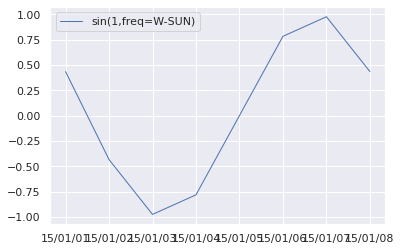

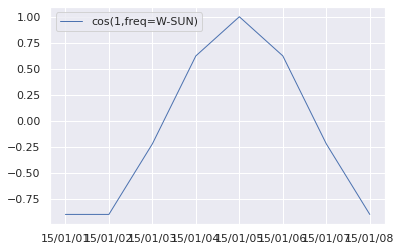

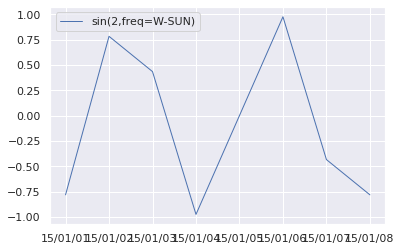

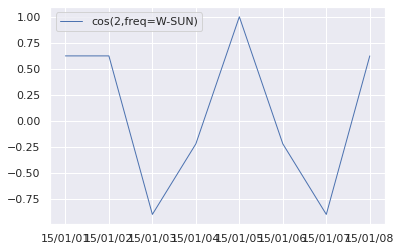

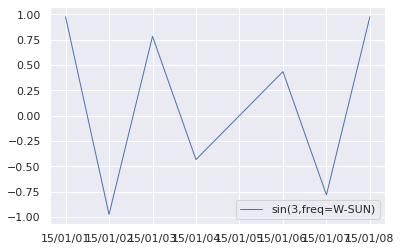

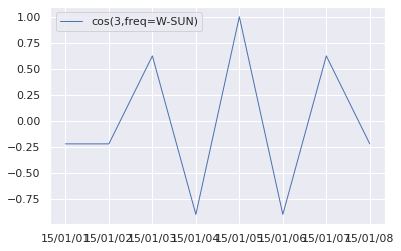

In [5]:
# 1週間で1週、2週、、する波ができている
for col in X_week.columns:
  fig = plt.figure()
  ax =fig.add_subplot(111)
  curve = X_week.loc["2015-01-01": "2015-01-08"][col].to_numpy()
  index = y.loc["2015-01-01": "2015-01-08"].index
  ax.plot(index, curve, linewidth=1.0, label=f"{col}")
  ax.xaxis.set_major_formatter(DateFormatter("%y/%m/%d"))
  plt.legend()
plt.show()
plt.close()

In [6]:
# 1年で1週、2週、、する波ができている
fourier_annual = CalendarFourier(freq="A", order=10)
dp_annual = DeterministicProcess(
    index=y.index,
    constant=True, # 切片追加しておく
    additional_terms=[fourier_annual]
)
X_annual = dp_annual.in_sample()
X_annual.head()

,const,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-02,1.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2015-01-03,1.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2015-01-04,1.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,0.255353,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2015-01-05,1.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,0.337523,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


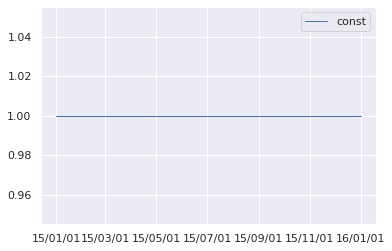

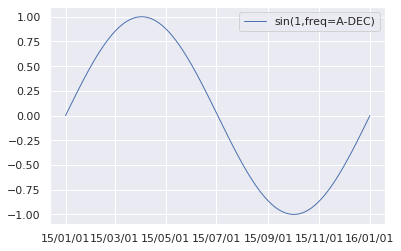

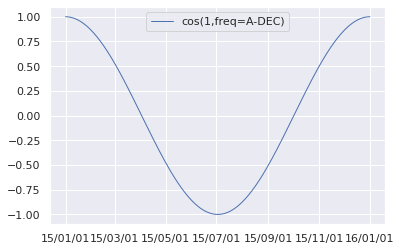

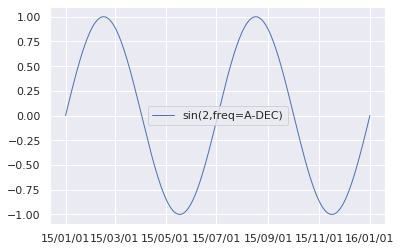

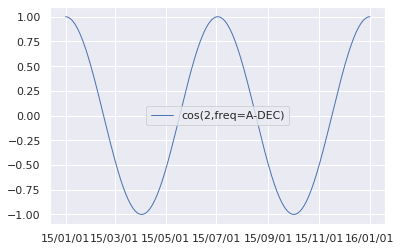

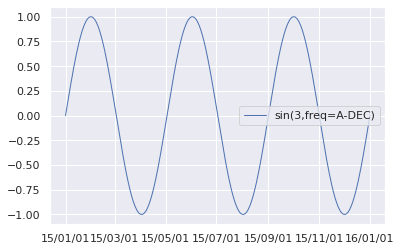

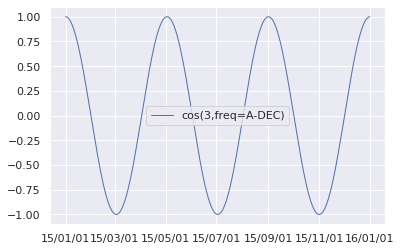

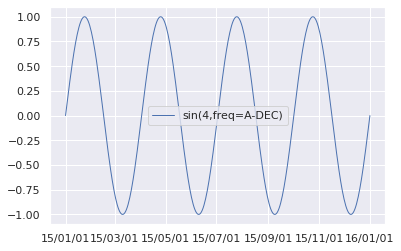

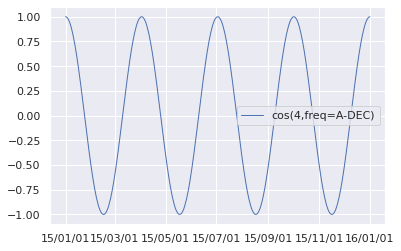

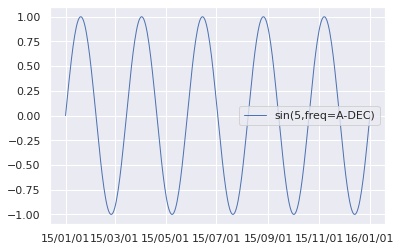

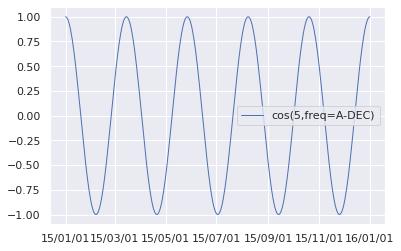

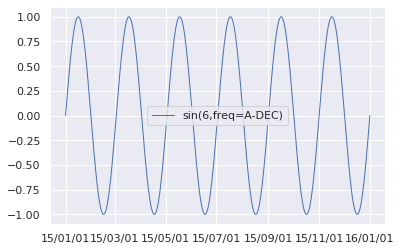

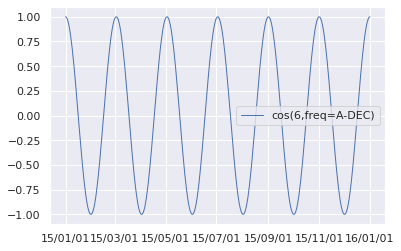

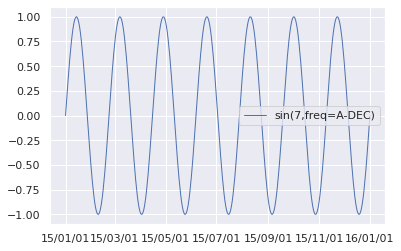

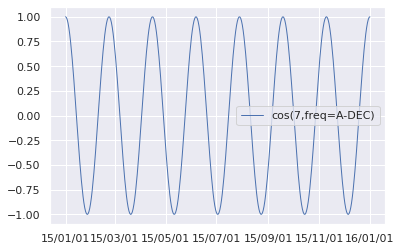

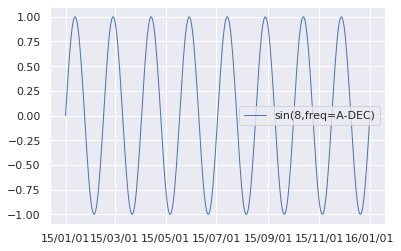

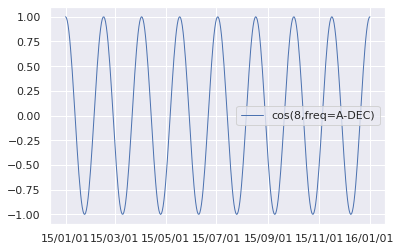

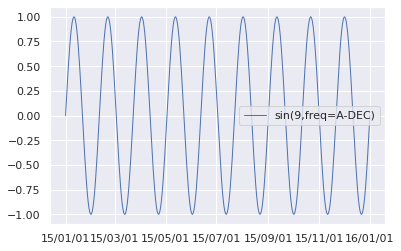

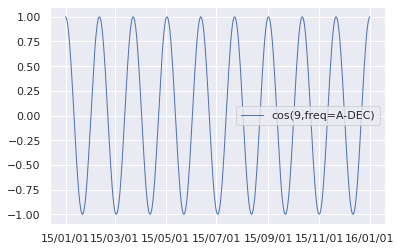

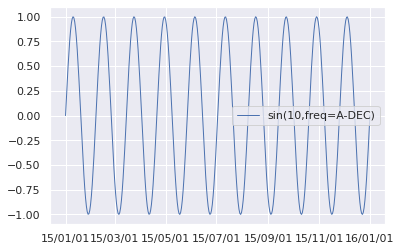

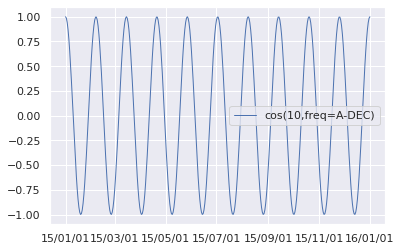

In [7]:
for col in X_annual.columns:
  fig = plt.figure()
  ax =fig.add_subplot(111)
  curve = X_annual.loc["2015-01-01": "2016-01-01"][col].to_numpy()
  index = y.loc["2015-01-01": "2016-01-01"].index
  ax.plot(index, curve, linewidth=1.0, label=f"{col}")
  ax.xaxis.set_major_formatter(DateFormatter("%y/%m/%d"))
  plt.legend()
plt.show()
plt.close()

In [8]:
# 作った特徴量をつなげる
X = pd.concat([X_week, X_annual], axis=1)
print(len(X.columns))
X.head()

27


,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",const,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,1.0,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-02,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,1.0,0.017213,0.999852,0.034422,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2015-01-03,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,1.0,0.034422,0.999407,0.068802,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2015-01-04,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,1.0,0.051620,0.998667,0.103102,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2015-01-05,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.0,0.068802,0.997630,0.137279,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157


フーリエ級数展開した特徴量で当てはめ

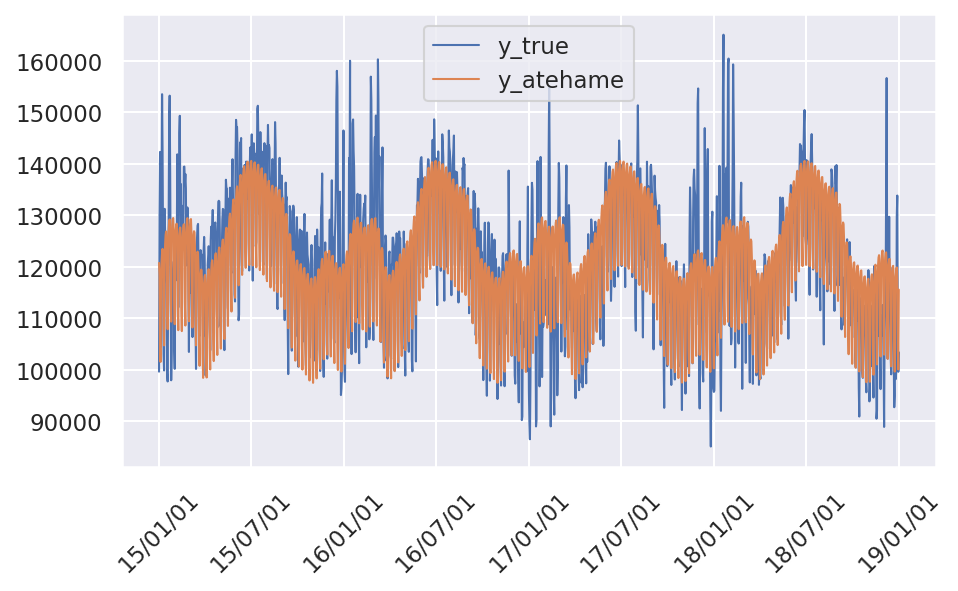

In [9]:
# 周期成分だけで予測
y_train = df.loc["2015-01-01" : "2018-12-31"]["demand"]
X_train = X.loc["2015-01-01" : "2018-12-31"]
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

fig = plt.figure(figsize=(7, 4), dpi=150)
ax =fig.add_subplot(111)
index = y_train.index

ax.plot(index, y_train, linewidth=1.0, label="y_true")
ax.plot(index, y_pred, linewidth=1.0, label="y_atehame")
ax.xaxis.set_major_formatter(DateFormatter("%y/%m/%d"))
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.close()

テストで予測精度

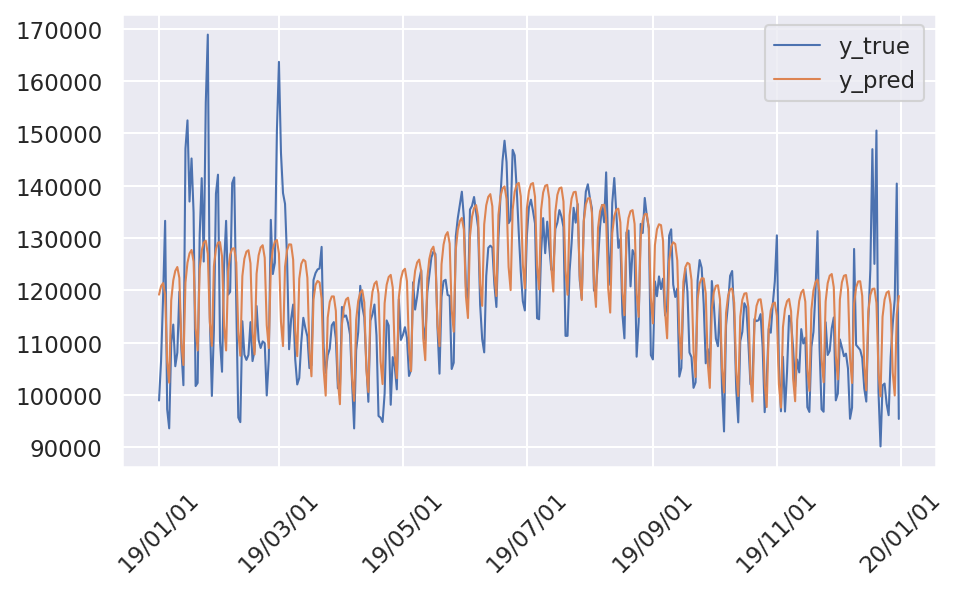

In [10]:
# 周期成分だけで予測
y_test = df.loc["2019-01-01" : "2019-12-31"]["demand"]
X_test= X.loc["2019-01-01" : "2019-12-31"]
y_pred = model.predict(X_test)

fig = plt.figure(figsize=(7, 4), dpi=150)
ax =fig.add_subplot(111)
index = y_test.index
ax.plot(index, y_test, linewidth=1.0, label="y_true")
ax.plot(index, y_pred, linewidth=1.0, label="y_pred")
ax.xaxis.set_major_formatter(DateFormatter("%y/%m/%d"))
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.close()

予測精度

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print(f"CORR：{np.corrcoef(y_test, y_pred)[0][1]}")
print(f"RMSE：{mean_squared_error(y_test, y_pred, squared=False)}")
print(f"MAE：{mean_absolute_error(y_test, y_pred)}")
print(f"MAPE：{mean_absolute_percentage_error(y_test, y_pred)}")

CORR：0.7110183458733025
RMSE：10248.982006051434
MAE：7795.144478829267
MAPE：0.06691561907647608


曜日と日にちの影響度を可視化する

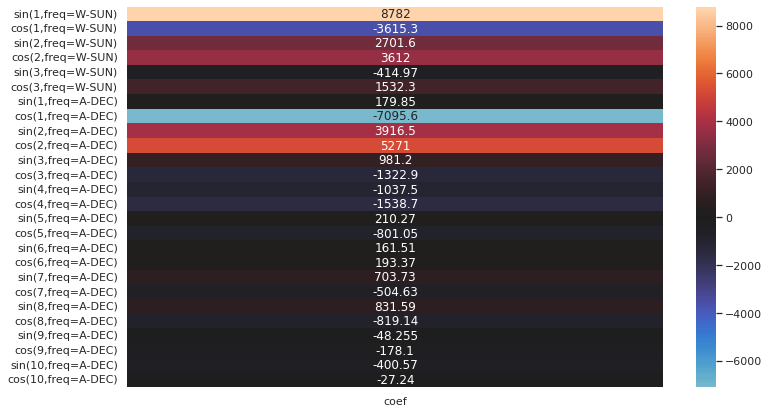

In [12]:
coef = model.coef_
coef = np.append(coef[0:6], coef[7:]).reshape(-1, 1) # coef[6]に入ってる切片がデカすぎてヒートマップが潰れるので抜く
ex_col = X.columns.drop(["const"])

plt.figure(figsize=(12, 7))
sns.heatmap(coef, xticklabels=["coef"], yticklabels=ex_col, center=0, annot=True, fmt=".5g")

曜日と1年の周期成分を取り出してみる  
例えば曜日成分を表す下の式でt=0を入れると月曜日の曜日成分が取り出せる

$$
y(t) = {\displaystyle{\sum_{k=1}^{3}}a_{k}\sin \frac{2\pi{k}{t}}{7} + b_{k}\cos \frac{2\pi{k}{t}}{7}}
$$
回帰係数の結果から
$$
a_{1} = 8782,  
b_{1} = -3615.3,  
a_{2} = 2701.6,  
b_{2} = 3612,  
a_{3} = -414.97,  
b_{3} = 1532.3
$$

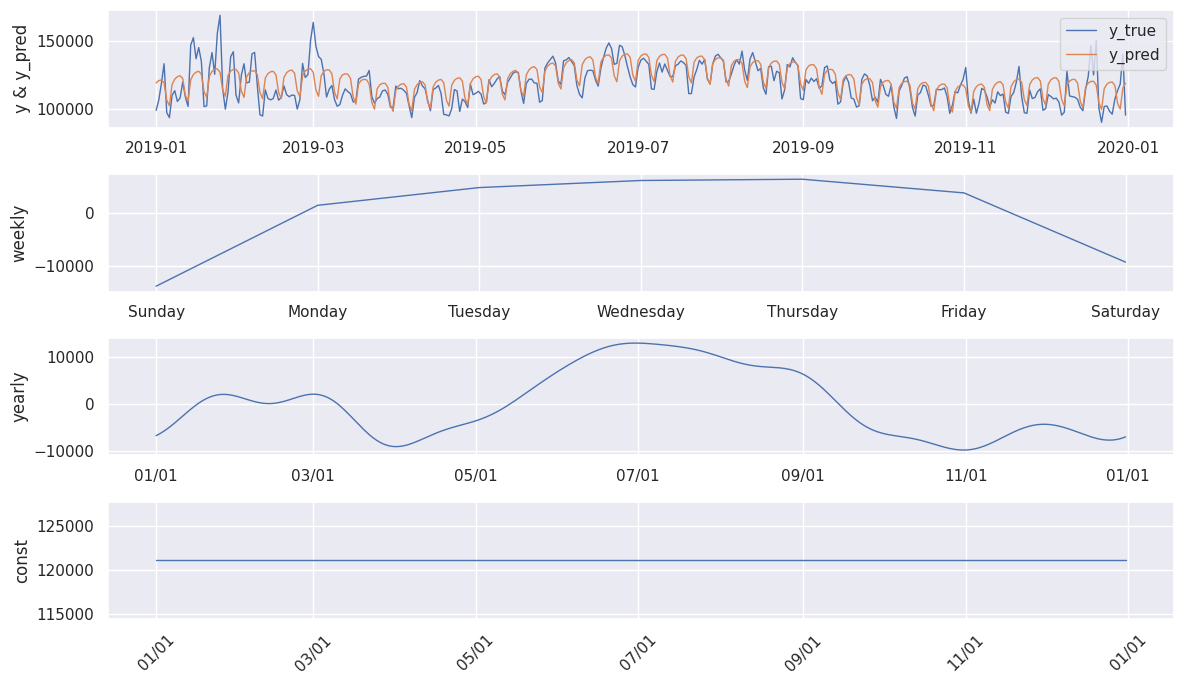

In [13]:
coef_week =  model.coef_[0:6] # 週に関するフーリエ係数を取り出す
X_week = X[X.columns[0:6]].to_numpy() # 月曜から日曜を表す特徴量を取り出す
z = (X_week @ coef_week).tolist()[0:7] # フーリエ係数と各曜日の特徴量を掛け算して、各曜日の影響度を計算する
x_week = X.index.day_name().tolist()[0:7]
# 2015年1月1日が木曜日なので日曜日が先頭になるように並び替え
z_week = [z[(i+3)%7] for i in range(len(z))] 
x_week = [x_week[(i+3)%7] for i in range(len(x_week))]

coef_annual =  model.coef_[7:] # 日にちに関するフーリエ級数を取り出す
X_annual = X[X.columns[7:]].to_numpy() # 月曜から日曜を表す特徴量を取り出す
z_annual = (X_annual @ coef_annual).tolist()[0:365] # フーリエ級数と各曜日の特徴量を掛け算して、各曜日の影響度を計算する
x_annual = X.index.tolist()[0:365]

fig = plt.figure(figsize=(12, 7), dpi=100)
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.plot(index, y_test, linewidth=1.0, label="y_true")
ax1.plot(index, y_pred, linewidth=1.0, label="y_pred")
ax2.plot(x_week, z_week, linewidth=1.0)
ax3.plot(x_annual, z_annual, linewidth=1.0)
ax4.plot(x_annual, [model.coef_[6]]*len(x_annual), linewidth=1.0)
ax3.xaxis.set_major_formatter(DateFormatter("%m/%d"))
ax4.xaxis.set_major_formatter(DateFormatter("%m/%d"))
ax1.set_ylabel("y & y_pred")
ax2.set_ylabel("weekly")
ax3.set_ylabel("yearly")
ax4.set_ylabel("const")
ax1.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()